In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
import dxfgrabber
from ezdxf.groupby import groupby
import scipy.interpolate

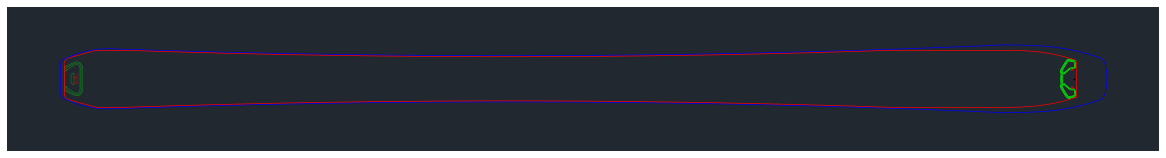

In [107]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile('DY-S76-176-1.dxf')
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)

Get all entities in each layer

In [108]:
msp = doc.modelspace()
group = groupby(entities=msp, dxfattrib='layer')
group = msp.groupby(dxfattrib='layer')

for layer, entities in group.items():
    print(f'Layer "{layer}" contains following entities:')
    for entity in entities:
        print('    {}'.format(str(entity)))


Layer "Accessoires" contains following entities:
    INSERT(#2099)
Layer "Peau" contains following entities:
    LINE(#20C6)
    ARC(#20C8)
    ARC(#20C9)
    LINE(#20CA)
    CIRCLE(#20CC)
    LINE(#20CD)
    LINE(#210C)
    LINE(#210D)
    INSERT(#213E)
    INSERT(#219A)
    INSERT(#21FD)
    INSERT(#21FE)
    ELLIPSE(#2201)
    SPLINE(#2202)
    SPLINE(#2203)
    LINE(#2206)
    SPLINE(#2207)
    LINE(#2208)
    SPLINE(#2209)
    LINE(#220A)
    ELLIPSE(#220B)
    LINE(#220C)
    CIRCLE(#220D)
Layer "TAIL-HOOK-2013-2D-PATCH" contains following entities:
    INSERT(#20CB)
Layer "2_Ski" contains following entities:
    LINE(#2101)
    SPLINE(#2102)
    SPLINE(#2103)
    SPLINE(#2104)
    SPLINE(#2105)
    SPLINE(#2106)
    SPLINE(#2107)


Plot control points from spline and line in SKI LAYER

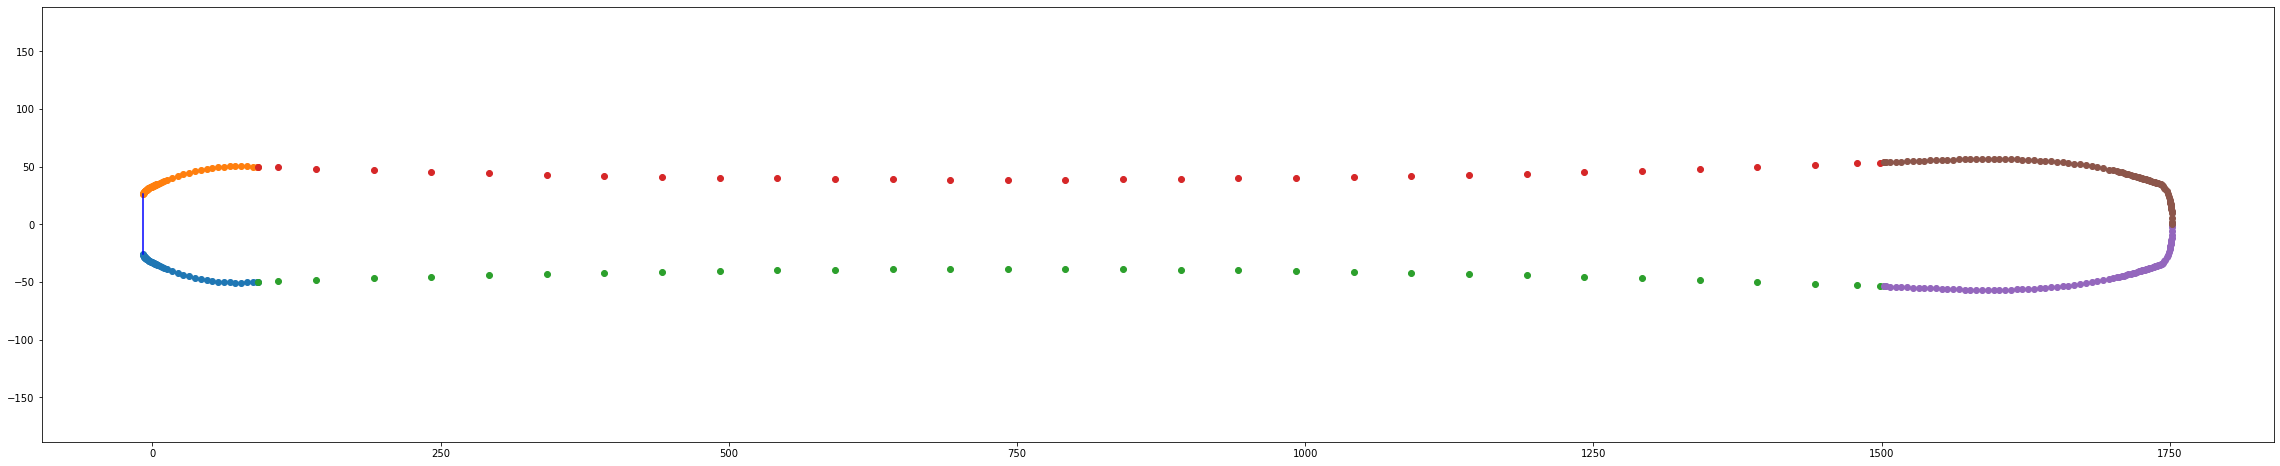

In [110]:
plt.figure(figsize=(40, 8))

for spline in msp.query('SPLINE[layer=="2_Ski"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
   
    plt.plot(np.array(spline.control_points)[:,0],np.array(spline.control_points)[:,1], 'o')

for line in msp.query('LINE[layer=="2_Ski"]'):
    plt.plot([np.array(line.dxf.start)[0],np.array(line.dxf.end)[0]],[np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]],'b-')

plt.axis('equal')
plt.show()

Shift the offset and flip data to have tip at zero length. Save minimum and maximum values.

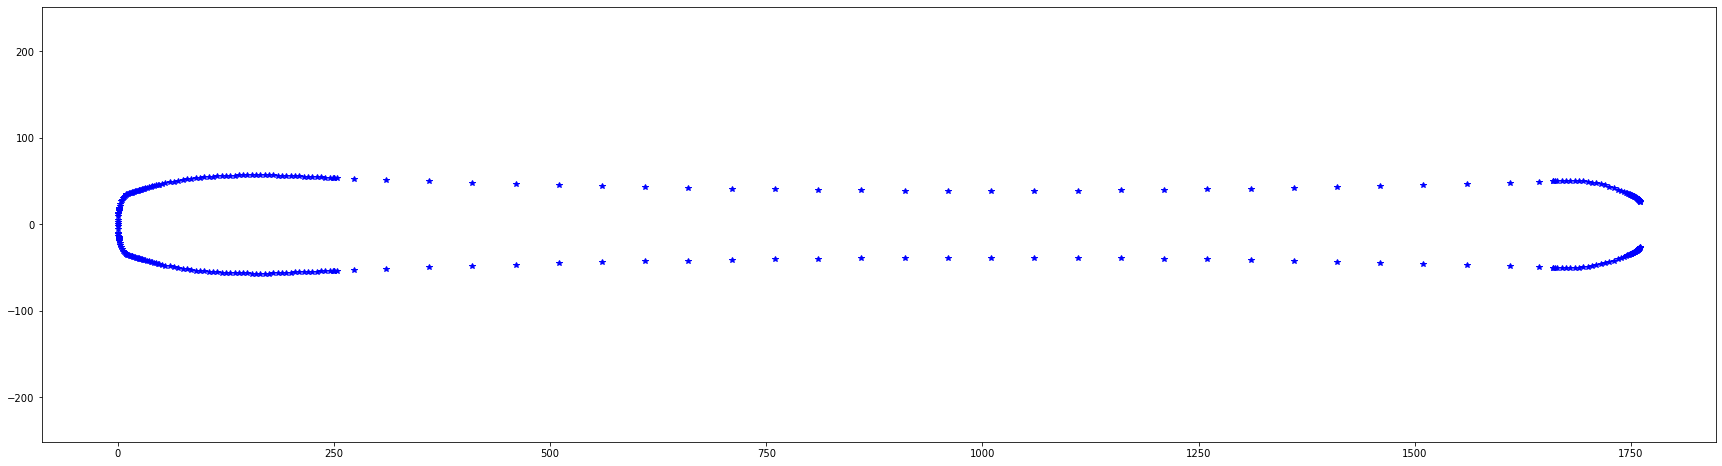

In [136]:
tot_x = []
tot_y = []
for spline in msp.query('SPLINE[layer=="2_Ski"]'):
    points = np.array(spline.control_points)
    x_nodes = points[:,0] 
    y_nodes = points[:,1]
    
    if x_nodes[0] > x_nodes[1]:
        x_nodes = x_nodes[::-1]
        y_nodes = y_nodes[::-1]
        
    tot_x = np.append(tot_x, x_nodes)   
    tot_y = np.append(tot_y, y_nodes)  
    
minimum = np.min(tot_x)

tot_x = tot_x - minimum

maximum = np.max(tot_x)

tot_x = tot_x - maximum
tot_x = -tot_x

plt.figure(figsize=(30, 8))

plt.plot(tot_x, tot_y, 'b*', label='myspline')
plt.axis('equal')
plt.show()


Define function to shift and flip data.

In [140]:
def flipnshift(x_points, minimum, maximum):
    
    out = x_points - minimum
    out = out - maximum
    out = -out
    
    return out

Load and plot sensors data.

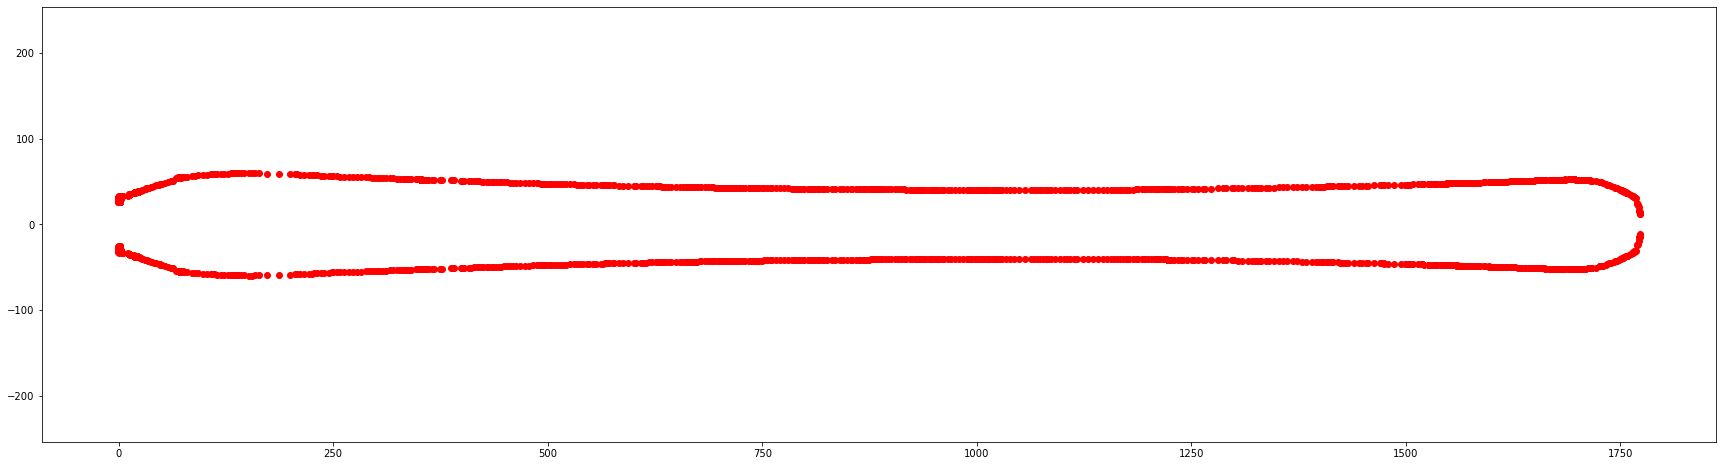

In [141]:
ski_profile = pd.read_csv(r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\sensorsdata.csv', sep = ",")

ski_profile = ski_profile*10 #To get mm values
# Plot two sides of the ski
ski_profile = ski_profile.sort_values('L',ascending=True)
plt.figure(figsize=(30, 8))

plt.plot(ski_profile['L'], ski_profile['W'], 'ro')
plt.plot(ski_profile['L'], -ski_profile['W'], 'ro')

plt.axis('equal')
plt.show()


Define function to find the closest point of a dataframe array to a point

In [142]:
def closest_point(point, df):
    delta = 10
    close_interval = df[abs(df-point) < delta] 
    min_dist = 1000 #initialise the minimum distance to a very high value
    closest_value = [] #initialise a variable to save the closest point among the points in the interval
    for j in range(1,len(close_interval)): #iterate over the selected interval
        
        a = point
        b = close_interval.iloc[j]
        
        dist = np.linalg.norm(a-b)
        if (dist < min_dist):
            min_dist = dist
            closest_value = b
    
    return closest_value

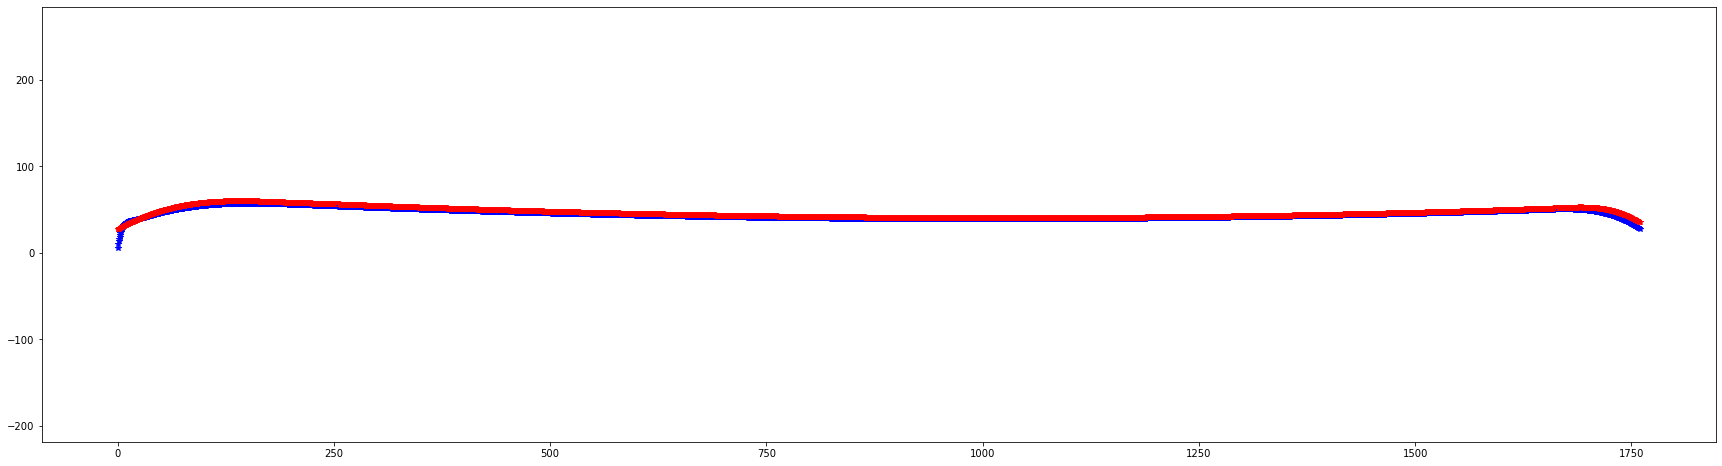

In [143]:
plt.figure(figsize=(30, 8))
tot_y_sensors = []
tot_x = []
tot_y = []
#for each spline in the dxf file
for spline in msp.query('SPLINE[layer=="2_Ski"]'):
    
    start_point = []
    end_point = []
    
    points = np.array(spline.control_points)
    
    x_nodes_RAW = points[:,0] 
    x_nodes = flipnshift(x_nodes_RAW, minimum, maximum)
    
    y_nodes = points[:,1]
        
    if x_nodes[0] > x_nodes[1]:
        x_nodes = x_nodes[::-1]
        y_nodes = y_nodes[::-1]
        points = points[::-1]
    
    if y_nodes[1]> 0:
        # Find closest start and end points in ski profile
        start_point = closest_point(x_nodes[0],ski_profile['L'])    

        end_point = closest_point(x_nodes[-1],ski_profile['L'])
    
        #For each spline create myspline for sensors' data
        section = ski_profile[['L','W']][ (ski_profile['L']>=start_point) & (ski_profile['L']<end_point)]

        myspline_sensors = scipy.interpolate.UnivariateSpline(section['L'].to_numpy(), section['W'].to_numpy())

        #For each spline create myspline from control_points
        myspline_dxf = scipy.interpolate.UnivariateSpline(x_nodes, y_nodes)
        myspline_knots = myspline_dxf.get_knots()
        myspline_coeffs = myspline_dxf.get_coeffs()

        #Oversampling
        x = np.arange(x_nodes[0], x_nodes[-1], 0.5)
        x = np.sort(x)
        tot_x = np.append(tot_x, x)

        #Myspline evaluation in more points
        y_myspline_dxf = myspline_dxf(x)
        tot_y = np.append(tot_y,y_myspline_dxf)

        y_myspline_sensors = myspline_sensors(x)
        tot_y_sensors = np.append(tot_y_sensors,y_myspline_sensors)

        plt.plot(x, y_myspline_dxf, 'b*', label='myspline')
        plt.plot(x, y_myspline_sensors, 'r*', label='myspline')
        #plt.plot(x, -y_myspline_sensors, 'r*', label='myspline')

#plt.plot(tot_x, tot_y, 'b*', label='myspline')
#plt.plot(ski_profile['L'], ski_profile['W'], 'ro')
#plt.plot(ski_profile['L'], -ski_profile['W'], 'ro')

plt.axis('equal')
plt.show()

Print the difference between the two curves and compute the error term (area betweem curves)

3225.449732373554


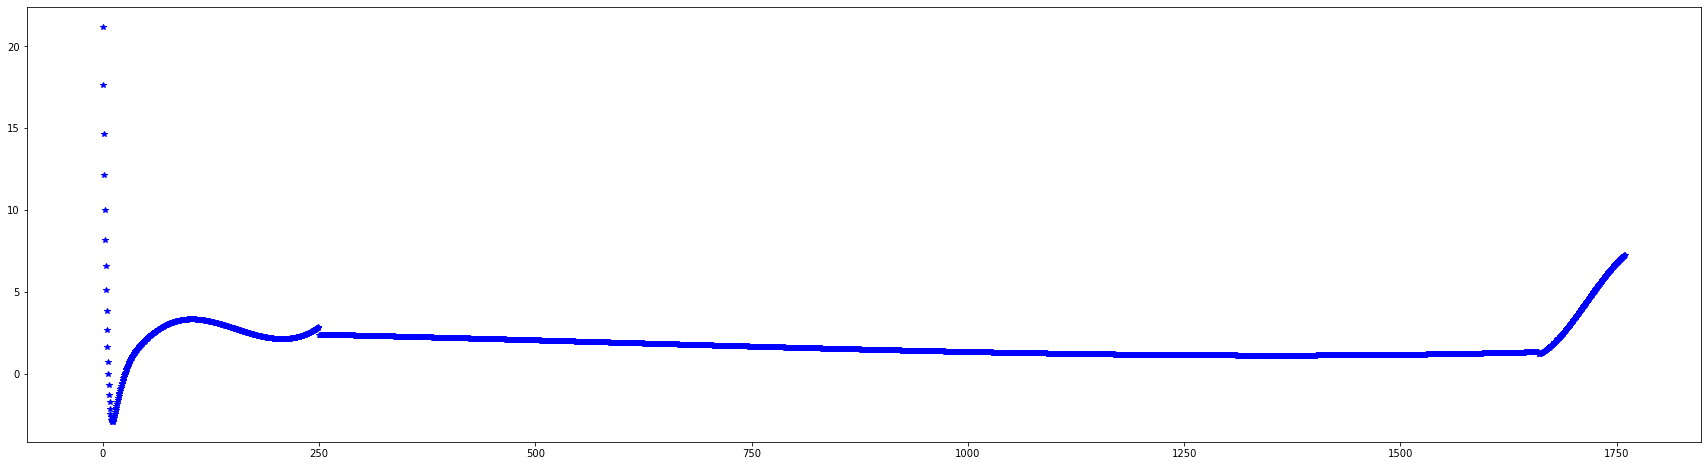

In [144]:
z = tot_y_sensors[:-1] - tot_y[:-1]
dx = 0.5
area = np.sum(np.absolute(z)*dx)
print(area)
plt.figure(figsize=(30, 8))
plt.plot(tot_x[:-1], z, 'b*')
plt.show()